In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

# from warpctc_pytorch import CTCLoss

/Users/adamschiller/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'

!ls {PATH}

ascii                 paragraph_chars.csv   tmp
chars.csv             paragraphs            words
forms                 paragraphs.csv        words.csv
line_chars.csv        paragraphs.tar.gz     words10.csv
line_labels.csv       paragraphs_df.csv     words_chars.csv
lines                 sentences             xml
models                synth_words           xml.tgz
multi_synth_words     synth_words.csv
multi_synth_words.csv synth_words_1000.csv


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Synthetic Data

### images

In [13]:
synth_path = PATH/'multi_synth_words'
os.makedirs(synth_path, exist_ok=True)

In [6]:
# def create_img(files, fname):
#     imgs    = [ PIL.Image.open(PATH/'words'/f) for f in files ]
#     widths, heights = zip(*(i.size for i in imgs))

#     total_height = sum(heights)
#     max_width = max(widths)

#     new_im = Image.new('RGB', (max_width, total_height), color=(255,255,255))

#     y_offset = 0
#     for im in imgs:
#       new_im.paste(im, (0,y_offset))
#       y_offset += im.size[1]

#     new_im.save(synth_path/fname)

In [14]:
def create_img(files, fname, sz=None):
    if sz==None: sz=(1, len(files))  #(w,h)
    w = sz[0]
    h = sz[1]
        
    imgs    = [ PIL.Image.open(PATH/'words'/f) for f in files ]
    widths, heights = zip(*(i.size for i in imgs))
    
    max_height = max(heights)
    max_width  = max(widths)
    
    total_height = max_height * h #sum(heights)
    total_width  = max_width  * w

    new_im = Image.new('RGB', (total_width, total_height), color=(255,255,255))

    y_offset = 0
    x_offset = 0
    
    images = list(reversed(imgs))
    
    for row in range(h):
        x_offset = 0
        for col in range(w):
            i = images.pop()
            new_im.paste(i, (x_offset,y_offset))
            x_offset += (i.size[0]+50)
        y_offset += max_height

    new_im.save(synth_path/fname)

### pd.read_csv

In [15]:
df = pd.read_csv(f'{PATH}/ascii/words.txt', names=['filename','result','value'], escapechar='\\', delim_whitespace=True, skiprows=23, header=None, usecols=[0,1,8])
df.rename(columns={'value': 'word'}, inplace=True)

In [16]:
len(df)

75597

In [17]:
# remove errors
df = df[df.result != 'err']
len(df)

64750

In [18]:
# calculate character lengths
lgts = df.word.apply(len)  
df['char_len'] = lgts.astype('int32')

In [19]:
# lots of errors from pd.read_csv
# only keep rows w/ word length < 20
df = df[df.char_len < 20]

In [20]:
df.head()

,filename,result,word,char_len
0,a01-000u-00-05,ok,Gaitskell,9
1,a01-000u-00-06,ok,from,4
2,a01-000u-01-00,ok,nominating,10
3,a01-000u-01-01,ok,any,3
4,a01-000u-01-02,ok,more,4


In [21]:
df = df.loc[df['char_len'] > 3]

### manually created df

In [77]:
maxTextLen = 32
samples = []
chars = set()

f=open(f'{PATH}/ascii/words.txt')
for line in f:
    # ignore comment line
    if not line or line[0]=='#':
        continue

    lineSplit = line.strip().split(' ')
    assert len(lineSplit) >= 9

    fileName = lineSplit[0]

    # GT text are columns starting at 9
    gtText = ''.join(lineSplit[8:])[:maxTextLen]
    char_len = len(gtText)
    chars = chars.union(set(list(gtText)))

    # put sample into list
    samples.append([fileName, gtText, char_len])
    
data = np.stack(samples)
df = pd.DataFrame(data, columns=['filename', 'word', 'char_len'], )
df.head()

,filename,word,char_len
0,a01-000u-00-00,A,1
1,a01-000u-00-01,MOVE,4
2,a01-000u-00-02,to,2
3,a01-000u-00-03,stop,4
4,a01-000u-00-04,Mr.,3


In [78]:
df['char_len'] = df.char_len.astype('int32')
gt3 = df.loc[df['char_len'] > 3]

### Create Data

In [212]:
def create_synth_data(num):
    d={}
    for i in range(num):
        res = df.sample(6)
        files = list(map(lambda x: x+'.png', res.filename.values))
        label = ' '.join(res.word.values)

        fname = '{:04d}'.format(i)+'.png'
        create_img(files, fname, (2,3))
        d[fname] = label
    return d

d = create_synth_data(1000)
len(d)

10000

In [213]:
synth = pd.DataFrame({'filename': list(d.keys()), 'labels': list(d.values())})
synth.head()

,filename,labels
0,0000.png,lace- death four warily considerably without
1,0001.png,food twentieth Western been proved Rhodesia
2,0002.png,task choice being longshore which childless
3,0003.png,advisers that GENERAL were false example
4,0004.png,especially That step rolls know been


### Verify

In [ ]:
fig, axes = plt.subplots(5,2, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    row = synth.iloc[i]
    im = Image.open(synth_path/row.filename)
    ax.imshow(im)
    ax.set_title(row.labels)
    
plt.tight_layout(pad=0.2)

# Prelim

### Chars

In [230]:
chars = set()
for line in synth.labels:
    chars = chars.union(set(list(line)))
    
len(chars)

71

In [233]:
freq = Counter(char for word in synth.labels for char in word)
freq.most_common(25)

[(' ', 50000),
 ('e', 48515),
 ('t', 29202),
 ('a', 26088),
 ('i', 25911),
 ('r', 25646),
 ('n', 24615),
 ('s', 23796),
 ('o', 22734),
 ('l', 17346),
 ('h', 15649),
 ('d', 14129),
 ('c', 11933),
 ('u', 10707),
 ('m', 10263),
 ('g', 8734),
 ('p', 8360),
 ('y', 6601),
 ('w', 6464),
 ('f', 5658),
 ('b', 5269),
 ('v', 4722),
 ('k', 2566),
 ('-', 908),
 ('T', 906)]

### Numericalize characters

In [234]:
itos = [char for char,count in freq.most_common()]
itos.insert(0, '_pad_')
# leave index 1 as ' '
itos.insert(2, '_eos_')
itos.insert(3, '_unk_')
len(itos)

74

In [235]:
joined_labels = list(synth.labels) #list(map(lambda x: ' '.join(x), labels))

stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[letter] for letter in word] + [2]) for word in joined_labels])

In [236]:
# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [237]:
synth['char_ids'] = str_ids
synth.head()

,filename,labels,char_ids
0,0000.png,lace- death four warily considerably without,12 6 15 4 26 1 14 4 6 5 13 1 22 11 16 8 1 21 6...
1,0001.png,food twentieth Western been proved Rhodesia,22 11 11 14 1 5 21 4 9 5 7 4 5 13 1 41 4 10 5 ...
2,0002.png,task choice being longshore which childless,5 6 10 25 1 15 13 11 7 15 4 1 23 4 7 9 18 1 12...
3,0003.png,advisers that GENERAL were false example,6 14 24 7 10 4 8 10 1 5 13 6 5 1 38 32 39 32 4...
4,0004.png,especially That step rolls know been,4 10 19 4 15 7 6 12 12 20 1 27 13 6 5 1 10 5 4...


In [240]:
# np.save(TMP_PATH/'synth_word_ids.npy', ids)
pickle.dump(itos, open(TMP_PATH/'multi_synth_itos.pkl', 'wb'))

### Save to CSV

In [5]:
# ids = np.load(TMP_PATH/'synth_word_ids.npy')
itos = pickle.load(open(TMP_PATH/'multi_synth_itos.pkl', 'rb'))

#### full dataset

In [6]:
CSV = PATH/'multi_synth_words.csv'
# CSV = PATH/'synth_words_50000.csv'

# synth.to_csv(CSV, columns=['filename', 'char_ids'], index=False)
csv = pd.read_csv(CSV)
csv.head()

,filename,char_ids
0,0000.png,12 6 15 4 26 1 14 4 6 5 13 1 22 11 16 8 1 21 6...
1,0001.png,22 11 11 14 1 5 21 4 9 5 7 4 5 13 1 41 4 10 5 ...
2,0002.png,5 6 10 25 1 15 13 11 7 15 4 1 23 4 7 9 18 1 12...
3,0003.png,6 14 24 7 10 4 8 10 1 5 13 6 5 1 38 32 39 32 4...
4,0004.png,4 10 19 4 15 7 6 12 12 20 1 27 13 6 5 1 10 5 4...


In [239]:
# length of longest string -> seq_len
csv.char_ids.map(lambda x: len(x.split(' '))).mean()
# max: 73
# mean: 43

43.2004

#### Append to DF

In [43]:
CSV = PATH/'synth_words_50000.csv'

new = pd.concat([csv, synth[['filename', 'char_ids']]], ignore_index=True)
new.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

#### sample (1000)

In [6]:
CSV = PATH/'multi_synth_words_1000.csv'

# csv = csv.sample(1000)
# csv.reset_index(drop=True, inplace=True)
# csv.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

csv = pd.read_csv(CSV)
len(csv)

1000

### Get val_idxs

In [7]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

1500

### Preprocess (rotate, normalize)

In [8]:
f = resnet34
sz = 128
bs = 30

In [49]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'multi_synth_words', CSV, bs=bs, val_idxs=val_idxs, 
                                    tfms=tfms, continuous=True)

In [50]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

### View image transforms

In [51]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

In [52]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[i] for i in ints])

In [53]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)

    #ax.set_axis_off()
    ax.set_yticks([16, 48, 80, 112], minor=True)
    ax.set_xticks([16, 48, 80, 112], minor=True)
    ax.set_yticks([32, 64, 96, 128], minor=False)
    ax.set_xticks([32, 64, 96, 128], minor=False)
    ax.yaxis.grid(True, which='both')
    ax.xaxis.grid(True, which='both')

    if title: ax.set_title(title)
    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


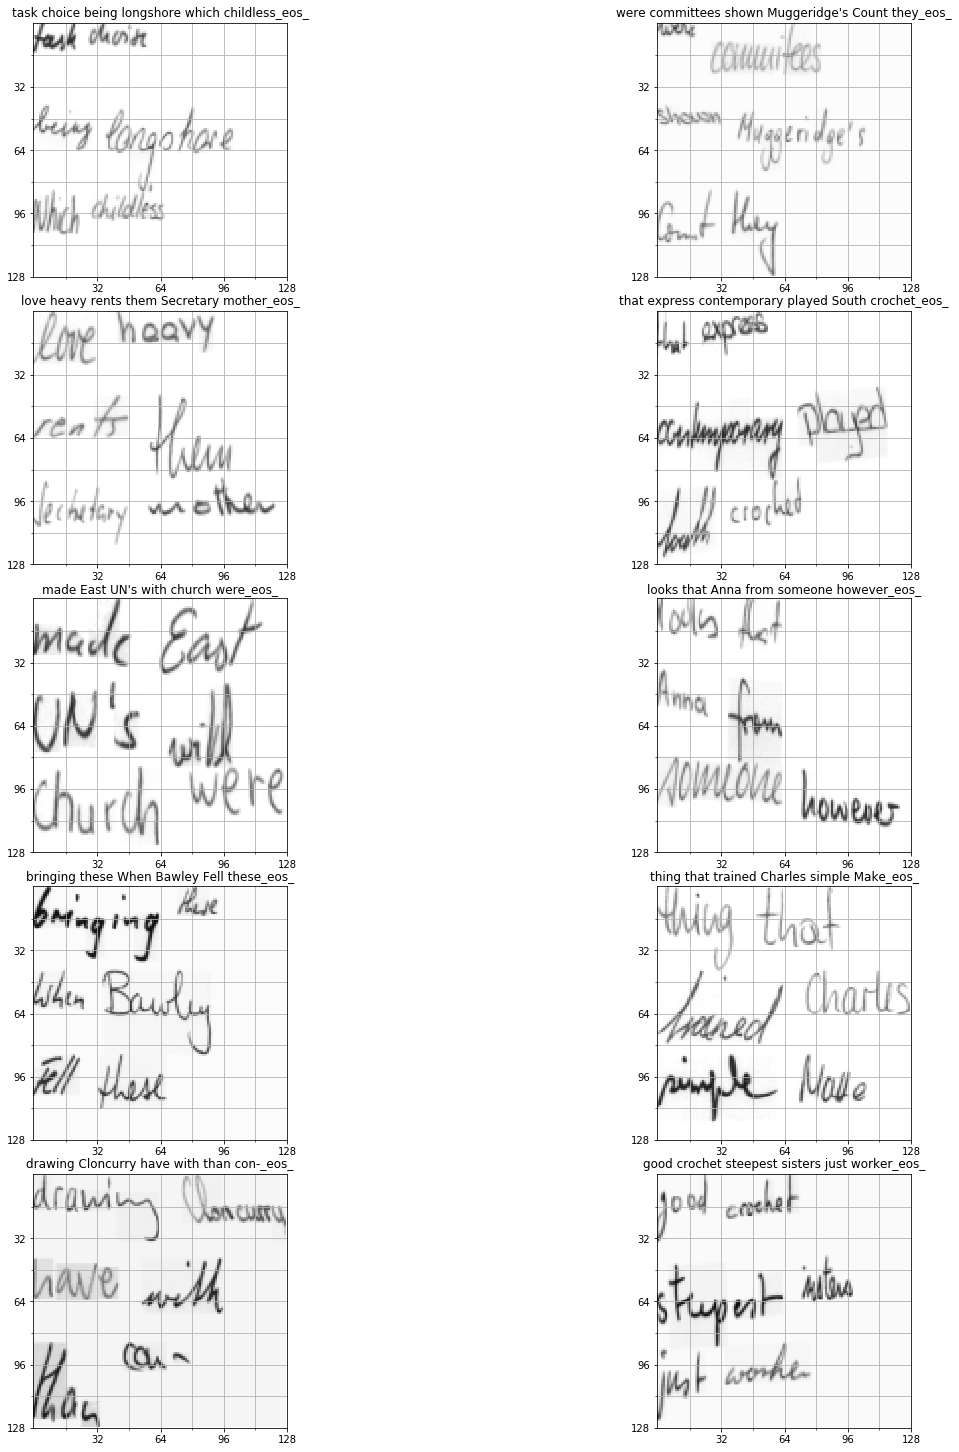

In [55]:
fig, axes = plt.subplots(5,2, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])
#     t = data.classes[y[i]]
    ax=show_img(x[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

# Loss fns

In [62]:
# categorical cross entropy loss
# list of probabilities for each word in vocab; target is correct word

def seq2seq_loss(input, target):
    target = target.permute(1,0).contiguous()
    tsl = target.size(0)
    sl,bs,nc = input.size()
    
    if sl>tsl: target = F.pad(target, (0,0,0,sl-tsl))
    if tsl>sl: target = target[:sl]
        
    targ = target.view(-1)
    pred = input.view(-1, nc)

    # combination of LogSoftmax and NLLLoss
    return F.cross_entropy(pred, targ.long(), reduction='sum')/bs

# Show, Attend, Tell

### Architecture

In [65]:
class Encoder(nn.Module):
    def __init__(self, embed_size, drop=0.4):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[embed_size]
        
        net = f(True)
        modules = list(net.children())[:s]    #(8,8,256)
        self.base = nn.Sequential(*modules)
        
        #mlp
        self.drop = nn.Dropout(drop)
        self.linear1 = nn.Linear(embed_size, embed_size)
        self.linear2 = nn.Linear(embed_size, embed_size)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()
        
        features = self.base(inp)
        features = features.flatten(2, 3).permute(2, 0, 1)
        
        # initial hidden is an average of features fed through an MLP
        h = self.drop(features)
        h = self.linear2(F.relu(self.linear1(h))).mean(0)
                        
        return features, h

In [58]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, drop=0.1):
        super().__init__()

        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.drop   = nn.Dropout(drop)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, hidden, feats):
        # this is called once for each timestep
        w1e = self.attn_1(feats)                    # ([64, 30, 256])
        w2h = self.attn_2(hidden)                   # ([30, 256])
        u = torch.tanh(w1e + w2h)                   # ([64, 30, 256])
        u = self.drop(u)
        a = torch.softmax(u @ self.attn_v, 0)       # ([64, 30]) - attention mask
        context = (a.unsqueeze(2) * feats).sum(0)   # ([30, 256]) - weighted sum of features w/ attention
        
        return context, a

In [59]:
class RNNDecoder(nn.Module):
    def __init__(self, embed_size, num_layers, drop=0.3):
        super().__init__()
        
        self.num_layers = num_layers
        self.rnn = nn.GRU(embed_size, embed_size, num_layers)
        if self.num_layers > 1: self.rnn.dropout = drop

    def forward(self, hidden, context):
        _, h = self.rnn(context.unsqueeze(0), hidden.expand(self.num_layers, -1, -1).contiguous())
        
        return h[-1]

In [16]:
# class LinearDecoder(nn.Module):
#     def __init__(self, embed_size, drop=0.3):
#         super().__init__()
        
#         self.linear1 = nn.Linear(embed_size, embed_size)
#         self.linear2 = nn.Linear(embed_size, embed_size)
#         self.drop = nn.Dropout(drop)

#     def forward(self, hidden, context):
#         h = self.linear1(hidden)
#         c = self.linear2(context)
#         g = torch.nn.functional.glu(torch.cat([h,c], 1))
        
#         return self.drop(g)

In [60]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size, drop=0.3):
        super().__init__()
        
        self.w0 = nn.Linear(embed_size, embed_size)
        self.w1 = nn.Linear(embed_size, embed_size)
        self.w2 = nn.Linear(embed_size, embed_size)
        self.w3 = nn.Linear(embed_size*3, vocab_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, prev, hidden, context):
        # this is called once for each timestep
        #(30,256)
        a = self.w0(prev)
        b = self.w1(hidden)
        c = self.w2(context)
        out = torch.cat([a,b,c], 1)
        
        return self.w3(self.drop(out))

In [66]:
class Net(nn.Module):
    def __init__(self, hidden_size, vocab_size, seq_len, n_layers=1, drop=0.2):
        super(Net, self).__init__()
        self.seq_len = seq_len
        
        self.encoder = Encoder(hidden_size)
        self.attention = Attention(hidden_size)
        self.decoder = RNNDecoder(hidden_size, n_layers)
#         self.decoder = LinearDecoder(hidden_size)
        
        self.embed   = nn.Embedding(vocab_size, hidden_size)
        self.drop    = nn.Dropout(drop)
        self.embed.weight.data.uniform_(-0.1, 0.1)

        self.output  = DeepOutputLayer(hidden_size, vocab_size)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats, hidden = self.encoder(x)
        
        res,attns = [],[]
        dec_inp = torch.ones(bs, device=device).long()
        
        for i in range(self.seq_len):
            prev = self.drop(self.embed(dec_inp))
            
            context, a = self.attention(hidden, feats)
            hidden = self.decoder(hidden, context)
            out = self.output(prev, hidden, context)
            
            res.append(out)
            attns.append(a)
            dec_inp = out.data.max(1)[1]
            
        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

In [67]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(itos), 50, 1)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss

# added Regularization

### Preprocess

In [10]:
f = resnet34
sz = 128
bs = 30

In [11]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'synth_words', CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)

In [12]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

### Architecture

In [23]:
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        
        net = f(True)
        modules = list(net.children())[:-3]    #(8,8,256)
        self.base = nn.Sequential(*modules)

        #mlp
        self.drop = nn.Dropout(0.4)
        self.linear1 = nn.Linear(256, embed_size)
        self.linear2 = nn.Linear(embed_size, embed_size)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()
        
        features = self.base(inp)    
        features = features.flatten(2, 3).permute(2, 0, 1)
        
        # initial hidden is an average of features fed through an MLP
        h = self.drop(features)
        h = self.linear2(F.relu(self.linear1(h))).mean(0)
                        
        return features, h

In [14]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

In [15]:
class WeightDrop(torch.nn.Module):
    def __init__(self, module, dropout=0.5, weights=['weight_hh_l0']):
        super().__init__()
        self.module,self.weights,self.dropout = module,weights,dropout
        self._setup()

    def _setup(self):
        if isinstance(self.module, torch.nn.RNNBase):
            self.module.flatten_parameters = noop
            
        for name_w in self.weights:
            w = getattr(self.module, name_w)
            del self.module._parameters[name_w]
            self.module.register_parameter(name_w + '_raw', nn.Parameter(w.data))

    def _setweights(self):
        for name_w in self.weights:
            raw_w = getattr(self.module, name_w + '_raw')
            w = torch.nn.functional.dropout(raw_w, p=self.dropout, training=self.training)
            if hasattr(self.module, name_w):
                delattr(self.module, name_w)
            setattr(self.module, name_w, w)

    def forward(self, *args):
        self._setweights()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return self.module.forward(*args)

In [24]:
class Decoder(nn.Module):
    def __init__(self, embed_size, num_layers):
        super().__init__()
        
        self.rnn = nn.GRU(embed_size, embed_size, num_layers, bidirectional=False)#, dropout=0.3)
#         self.rnn = WeightDrop(self.rnn)
        
        # Attention Layers
        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, prev_embed, hidden, feats):
        # this is called once for each timestep
        w1e = self.attn_1(feats)                    # ([64, 30, 256])
        w2h = self.attn_2(hidden)                   # ([30, 256])
        u = torch.tanh(w1e + w2h)                   # ([64, 30, 256])
        a = torch.softmax(u @ self.attn_v, 0)       # ([64, 30]) - attention mask
        context = (a.unsqueeze(2) * feats).sum(0)   # ([30, 256]) - weighted sum of features w/ attention

        _, h = self.rnn(context.unsqueeze(0), hidden.unsqueeze(0))  # replace w/ linear layers
        
        return h.squeeze(0), context, a

In [25]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size, drop):
        super().__init__()
        
        self.w0 = nn.Linear(embed_size, embed_size)
        self.w1 = nn.Linear(embed_size, embed_size)
        self.w2 = nn.Linear(embed_size, embed_size)
        self.w3 = nn.Linear(embed_size*3, vocab_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, prev, hidden, context):
        # this is called once for each timestep
        #(30,256)
        a = self.w0(prev)    # using previous embedding instead of previous input vector
        b = self.w1(hidden)
        c = self.w2(context)
        out = self.drop(torch.cat([a,b,c], 1))
        
        return self.w3(out)

In [17]:
# def dropout_mask(x, sz, dropout):
#     return x.new(*sz).bernoulli_(1-dropout)/(1-dropout)

# class LockedDropout(nn.Module):
#     def __init__(self, p=0.65):
#         super().__init__()
#         self.p=p

#     def forward(self, x):
#         if not self.training or not self.p: return x
#         m = dropout_mask(x.data, x.size(), self.p)
#         return Variable(m, requires_grad=False) * x

In [34]:
class Net(nn.Module):
    def __init__(self, hidden_size, vocab_size, seq_len, n_layers=1, dropout=0.4):
        super(Net, self).__init__()
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.initrange = 0.1
        
        self.encoder = Encoder(hidden_size)
        self.decoder = Decoder(hidden_size, n_layers)
        
        self.embed   = nn.Embedding(vocab_size, hidden_size)
        self.drop    = nn.Dropout(0.1)
        self.embed.weight.data.uniform_(-self.initrange, self.initrange)

        self.output  = DeepOutputLayer(hidden_size, vocab_size, dropout)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats, enc_h = self.encoder(x)
        
        res,attns = [],[]
        dec_inp = torch.ones(bs, device=device).long()
        hidden = enc_h
        
        for i in range(self.seq_len):
            prev = self.drop(self.embed(dec_inp))
            
            hidden, context, a = self.decoder(prev, hidden, feats)
            attns.append(a)
            out = self.output(prev, hidden, context)
            res.append(out)
            dec_inp = out.data.max(1)[1]
            
        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

In [ ]:
# def seq2seq_reg(output, xtra, loss, alpha=2, beta=1):
#     # Activiation Regularization
#     if alpha: loss = loss + sum(alpha * dropped_rnn_h.pow(2).mean() for dropped_rnn_h in dropped_rnn_hs[-1:])
#     # Temporal Activation Regularization (slowness)
#     if beta: loss = loss + sum(beta * (rnn_h[1:] - rnn_h[:-1]).pow(2).mean() for rnn_h in rnn_hs[-1:])
    
    
#     hs,dropped_hs = xtra
#     if alpha:  # Activation Regularization
#         loss = loss + (alpha * dropped_hs[-1].pow(2).mean()).sum()
#     if beta:   # Temporal Activation Regularization (slowness)
#         h = hs[-1]
#         if len(h)>1: loss = loss + (beta * (h[1:] - h[:-1]).pow(2).mean()).sum()
#     return loss

In [35]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(itos), 50, 1)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss

# learn.reg_fn = seq2seq_reg
# learn.reg_fn.alpha = 2
# learn.reg_fn.beta = 1

# Finer-grained attention - Resnet50

### Preprocess

In [62]:
f = resnet50
sz = 128
bs = 30

In [63]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'synth_words', CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)

In [64]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

### Architecture

In [65]:
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        
        net = f(True)
        modules = list(net.children())[:-4]    #([30, 512, 16, 16])
        self.base = nn.Sequential(*modules)

        #mlp
        self.drop = nn.Dropout(0.5)
        self.linear1 = nn.Linear(512, embed_size)
        self.linear2 = nn.Linear(embed_size, embed_size)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()
        
        features = self.base(inp)
                
        features = features.flatten(2, 3).permute(2, 0, 1)
        
        # initial hidden is an average of features fed through an MLP
        h = self.drop(features)
        h = self.linear2(F.relu(self.linear1(h))).mean(0)
                        
        return features, h

In [66]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

In [67]:
class WeightDrop(torch.nn.Module):
    def __init__(self, module, dropout=0.5, weights=['weight_hh_l0']):
        super().__init__()
        self.module,self.weights,self.dropout = module,weights,dropout
        self._setup()

    def _setup(self):
        if isinstance(self.module, torch.nn.RNNBase):
            self.module.flatten_parameters = noop
            
        for name_w in self.weights:
            w = getattr(self.module, name_w)
            del self.module._parameters[name_w]
            self.module.register_parameter(name_w + '_raw', nn.Parameter(w.data))

    def _setweights(self):
        for name_w in self.weights:
            raw_w = getattr(self.module, name_w + '_raw')
            w = torch.nn.functional.dropout(raw_w, p=self.dropout, training=self.training)
            if hasattr(self.module, name_w):
                delattr(self.module, name_w)
            setattr(self.module, name_w, w)

    def forward(self, *args):
        self._setweights()
        return self.module.forward(*args)

In [68]:
class Decoder(nn.Module):
    def __init__(self, embed_size, num_layers):
        super().__init__()
        
        self.dec_rnn = nn.GRU(embed_size, embed_size, num_layers, bidirectional=False)#, dropout=0.3)
        self.rnn = WeightDrop(self.dec_rnn)
        
        # Attention Layers
        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, prev_embed, hidden, feats):
        # this is called once for each timestep
        w1e = self.attn_1(feats)                    # ([64, 30, 256])
        w2h = self.attn_2(hidden)                   # ([30, 256])
        u = torch.tanh(w1e + w2h)                   # ([64, 30, 256])
        a = torch.softmax(u @ self.attn_v, 0)       # ([64, 30]) - attention mask
        context = (a.unsqueeze(2) * feats).sum(0)   # ([30, 256]) - weighted sum of features w/ attention

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            _, h = self.rnn(context.unsqueeze(0), hidden.unsqueeze(0))  # replace w/ linear layers
        
        return h.squeeze(0), context, a

In [69]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size, drop):
        super().__init__()
        
        self.w0 = nn.Linear(embed_size, embed_size)
        self.w1 = nn.Linear(embed_size, embed_size)
        self.w2 = nn.Linear(embed_size, embed_size)
        self.w3 = nn.Linear(embed_size*3, vocab_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, prev, hidden, context):
        # this is called once for each timestep
        #(30,256)
        a = self.w0(prev)    # using previous embedding instead of previous input vector
        b = self.w1(hidden)
        c = self.w2(context)
        out = self.drop(torch.cat([a,b,c], 1))
        
        return self.w3(out)

In [17]:
# def dropout_mask(x, sz, dropout):
#     return x.new(*sz).bernoulli_(1-dropout)/(1-dropout)

# class LockedDropout(nn.Module):
#     def __init__(self, p=0.65):
#         super().__init__()
#         self.p=p

#     def forward(self, x):
#         if not self.training or not self.p: return x
#         m = dropout_mask(x.data, x.size(), self.p)
#         return Variable(m, requires_grad=False) * x

In [70]:
class Net(nn.Module):
    def __init__(self, hidden_size, vocab_size, seq_len, n_layers=1, dropout=0.5):
        super(Net, self).__init__()
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.initrange = 0.1
        
        self.encoder = Encoder(hidden_size)
        self.decoder = Decoder(hidden_size, n_layers)
        
        self.embed   = nn.Embedding(vocab_size, hidden_size)
        self.drop    = nn.Dropout(dropout)
        self.embed.weight.data.uniform_(-self.initrange, self.initrange)

        self.output  = DeepOutputLayer(hidden_size, vocab_size, dropout)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats, enc_h = self.encoder(x)
        
        res,attns = [],[]
        dec_inp = torch.ones(bs, device=device).long()
        hidden = enc_h
        
        for i in range(self.seq_len):
            prev = self.drop(self.embed(dec_inp))
            
            hidden, context, a = self.decoder(prev, hidden, feats)
            attns.append(a)
            out = self.output(prev, hidden, context)
            res.append(out)
            dec_inp = out.data.max(1)[1]
            
        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

In [71]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(512, len(itos), 50, 1)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss

 50%|████▉     | 141/284 [00:47<00:48,  2.96it/s, loss=342] 

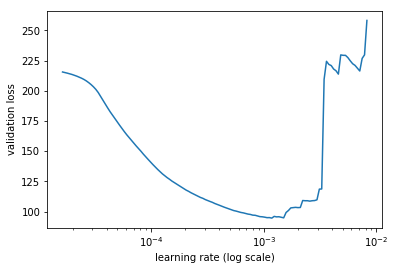

In [54]:
learn.lr_find()
learn.sched.plot(n_skip_end=1)

# Training

In [68]:
lr=1e-3
learn.fit(lr, 1, cycle_len=1)

  2%|▏         | 7/284 [00:36<23:43,  5.14s/it, loss=215]

KeyboardInterrupt: 

In [20]:
learn.fit(lr, 10, cycle_len=1, use_clr=(20, 8))

epoch      trn_loss   val_loss                              
    0      65.315627  64.931848 
    1      63.873344  63.401482                             
    2      63.2329    62.854062                             
    3      62.904706  62.212223                             
    4      61.451569  61.270003                             
    5      60.516647  60.79174                              
    6      60.206783  60.427918                             
    7      59.551505  60.020778                             
    8      58.352087  59.487703                             
    9      57.699566  58.904248                             



[58.904247512817385]

In [74]:
lr=1e-3
learn.fit(lr, 5, cycle_len=1, use_clr=(10, 4))

# 10000, em_sz:256, attn:64, layers:1
#     basic dropout, no other reg             60.891508  60.290612
#                                             58.606344  57.77362  (+5 more epochs) =>  39.976088  41.323369
#                                             61.740216  60.951465
#     "", concat prev_embed in decoder        61.910643  61.581217
#     reverse hidden, concat in decoder       60.79396   59.663209
#                                             63.193752  63.610585
#     "", 3 layer decoder                     63.848724  62.137234 (+5 more epochs) =>  46.06855   45.705343
#     "", looped 3 layer decoder              82.935375  114.947655
#     "", 1 layer dec, no hidden in output    63.761052  63.457554

#     1x1conv enc                             63.135926  62.052545
#     attn(prev, feats)                       62.396313  61.529537

#     glu linear decoder (+1 epoch)           60.460725  59.62591  (+5 more epochs) =>  44.773671  45.178832               
          
# larger embed size: 400
#     drop no reg; 1x1conv enc                61.741903  61.070376

# finer grained attn: 256
#     drop no reg; 1x1conv enc                very bad   69.000000
#     em_sz: 512; no 1x1conv                  64.780942  64.243546 (11 epochs) =>  57.699566  58.904248

  5%|▍         | 67/1417 [00:25<08:30,  2.65it/s, loss=66.1] 

KeyboardInterrupt: 

In [97]:
lr=1e-3  # large datasets
learn.fit(lr, 1, cycle_len=1)

#10000, bs:30, sz: 128, num_layers: 1, lr:1e-3, em_sz: 256, attn: 64
#     linear (not deep) output                  65.85
#     "", attn w/out prev_emb                   60.82
#     deep output - mlp                         nan
#     deep output - addition                    67.39
#     "", attn w/out prev_emb                   67.65
#     deep output - concat                      67.95
#     "", attn w/out prev_emb                   66.20, 66.58
#     "", "", dropouts                          66.79
#     Luong attn decoder                        66.36
#     hybrid attn                               66.88
#     "", lr:1e-4                               66.52

#     regularization                            66.26
#     "", incl weight drop                      67.76, 66.93
#     "", "", SGD                               217.95
#     linear decoder (no rnn)                   66.48

#     em_sz: 512, resnet50, attn: 256
#     regularization w/ weight drop             66.06

#50000, bs:30, sz: 128, num_layers: 1, lr:1e-3, em_sz: 256
#     deep out w/ concat, attn w/out prev_emb   62.21
#     "", attn: 256 (addt'l linear in encoder)  64.74                   

#50000, bs:30, sz: 128, num_layers: 1, lr:1e-3, em_sz: 512, resnet50, attn: 256
#     deep out w/ concat, attn w/out prev_emb   63.53


epoch      trn_loss   val_loss                                  
    0      5007.256299 68.421505 



[68.42150497436523]

In [73]:
learn.fit(lr, 3, cycle_len=1)

#        1000                               10000                           50000
# output addition
# 101.501918 74.087868                63.757736  64.09727

# "", attn w/out prev_emb             63.517634  64.084535

# output concat
# 99.965209  72.469034                63.361161  63.640719

# "", attn w/out prev_emb             62.51545   62.879461             34.817955  34.855359 '50000_deep_concat_4epochs' 
#                                     62.953349  63.237375

# linear (not deep) output
# 88.002041  69.246541                63.345379  62.93458    

# "", attn w/out prev_emb
# 106.108512 70.501785                64.519318  64.044387

# Luong Attention decoder             64.774495  64.690419
# hybrid attn                         62.88346   63.448279
# "", lr: 1e-4                        63.586683  64.314968

# Linear decoder                      65.599908  64.379403
# Regularization w/ weight drop       63.877057  63.602539, 
# "", SGD                             207.849781 207.626125

# em_sz: 512, resnet50, attn: 256
# Regularization w/ weight drop       63.908651  64.235812            39.845341  38.752754 '50000_resnet50_4epochs'

epoch      trn_loss   val_loss                                
    0      60.165763  60.201951 
    1      49.200957  48.113662                               
    2      39.845341  38.752754                               


[38.75275395202637]

In [74]:
learn.save('50000_resnet50_4epochs')

In [75]:
# lr = 1e-4
learn.fit(lr, 10, cycle_len=1, use_clr=(20, 8))

#10000
# linear (not deep) output      55.973263  56.410798  'showattendtell_1inear' (definitely working!!)
# "", attn w/out prev_emb       61.039778  61.661973
# deep output +, no prev_emb    48.431711  49.513662
# deep output concat            43.561881  44.510029  'showattendtell_deepconcat'
# "", attn w/out prev_emb       39.949578  42.628508  'showattendtell_deepconcat_noprev{_24epochs}' 23.402106  35.502501
# Luong Attention decoder       60.528437  63.590961
# Linear decoder                51.576132  51.269604
# Reg w/ weight drop            45.967312  46.825015
# Resnet50, attn256, em_sz512   42.832643  42.662761  'resnet50_emb512_14epochs'

#50000
# deep concat, w/out prev_emb   13.47356   17.998981  '50000_deep_concat_14epochs'
# Resnet50, attn256, em_sz512   18.836281  20.911904  '50000_resnet50_14epochs'

epoch      trn_loss   val_loss                                
    0      33.584971  33.862065 
    1      30.763955  30.304835                               
    2      28.111567  27.809246                               
    3      26.22169   25.631084                               
    4      23.938811  24.53827                                
    5      23.149856  23.64597                                
    6      21.906457  22.870015                               
    7      20.822609  21.445817                               
    8      20.543273  21.107787                               
    9      18.836281  20.911904                               


[20.911904094696045]

In [76]:
learn.save('50000_resnet50_14epochs')

In [ ]:
learn.fit(lr, 10, cycle_len=1, use_clr=(20, 8))

epoch      trn_loss   val_loss                                
    0      18.81008   19.849449 
    1      18.820391  19.635867                               
    2      17.553212  19.174573                               
    3      17.304403  18.829749                               
    4      17.245075  18.825651                               
    5      15.878905  18.499388                               
    6      15.576322  18.259816                               
    7      15.72893   17.997937                               
    8      14.713168  18.351366                               
Validation:  97%|█████████▋| 242/250 [00:30<00:01,  7.96it/s] 

In [ ]:
learn.save('50000_resnet50_24epochs')
#10000
# deep concat, w/out prev_emb    23.402106  35.502501      'showattendtell_deepconcat_noprev_24epochs'

#50000
# Resnet50, attn256, em_sz512    14.713168  18.351366      '50000_resnet50_24epochs'

In [20]:
learn.load('50000_deep_concat_14epochs_mod')

### update saved model parameter names

In [51]:
sd = torch.load(PATH/'models/50000_deep_concat_14epochs.h5', map_location=lambda storage, loc: storage)

In [54]:
sd["attention.attn_v"] = sd.pop("decoder.attn_v")
sd["attention.attn_1.weight"] = sd.pop("decoder.attn_1.weight")
sd["attention.attn_1.bias"] = sd.pop("decoder.attn_1.bias")
sd["attention.attn_2.weight"] = sd.pop("decoder.attn_2.weight")
sd["attention.attn_2.bias"] = sd.pop("decoder.attn_2.bias")
sd["decoder.rnn.weight_ih_l0"] = sd.pop("decoder.dec_rnn.weight_ih_l0")
sd["decoder.rnn.weight_hh_l0"] = sd.pop("decoder.dec_rnn.weight_hh_l0")
sd["decoder.rnn.bias_ih_l0"] = sd.pop("decoder.dec_rnn.bias_ih_l0")
sd["decoder.rnn.bias_hh_l0"] = sd.pop("decoder.dec_rnn.bias_hh_l0")

In [55]:
torch.save(sd, PATH/'models/50000_deep_concat_14epochs_mod.h5')

# Results

In [21]:
x,y = next(iter(data.val_dl))
learn.model.eval()
preds,attns = learn.model(x, ret_attn=True)   #attns ([sl, 64, bs])
# preds = learn.model(x)
res = torch.argmax(preds, dim=-1)

In [22]:
seq2seq_loss(preds, y)

tensor(13.9390, device='cuda:0', grad_fn=<DivBackward0>)

In [23]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[i] for i in ints])

In [60]:
for i in range(10):
    print(label_text(res[:,i]))

Cloncurry case That
Common with Unfortunately
that cought physical
with awwy decided
diaries Whigs take
pest cruel among
table have through
from They Govennment's
ripples greatly right
surronndings conference  aaiittee


## Images

In [24]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


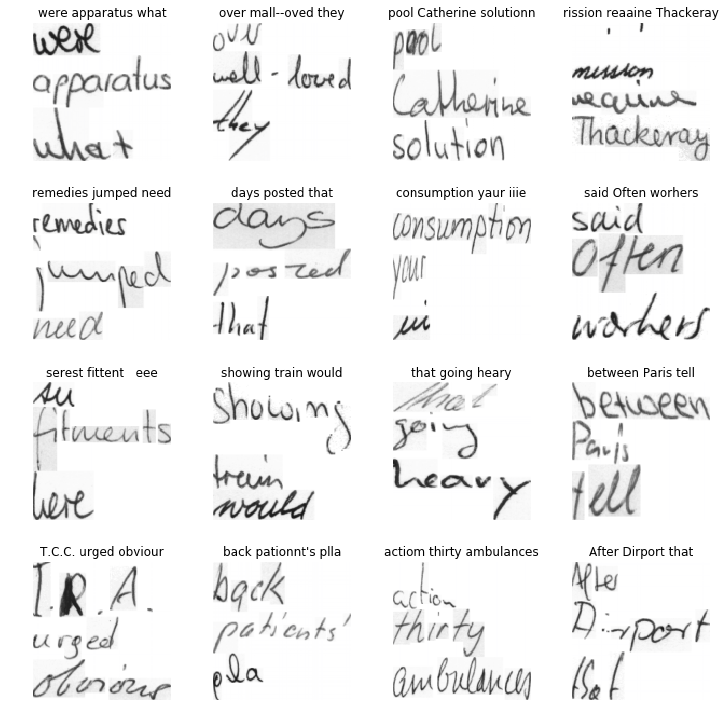

In [25]:
imgs = data.trn_ds.denorm(x)

fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])     #=>  char indices
    p = label_text(res[:,i])
    ax=show_img(imgs[i], ax=ax, title=p)#t+' '+p)
    
plt.tight_layout(pad=0.1)

## Attention

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


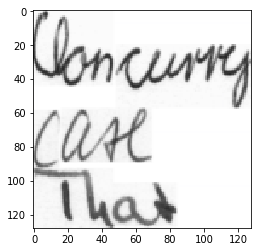

In [78]:
plt.imshow(imgs[0])

In [55]:
def scale_attn_to_img(att, sz):
    num = sz // 8
    a = att.reshape(8,8)
    return np.repeat(np.repeat(a,num, axis=0), num, axis=1)

In [56]:
idx  = 0
img  = imgs[idx]
pred = res[:,idx]
attn = to_np(attns[:,:,idx])  # first batch

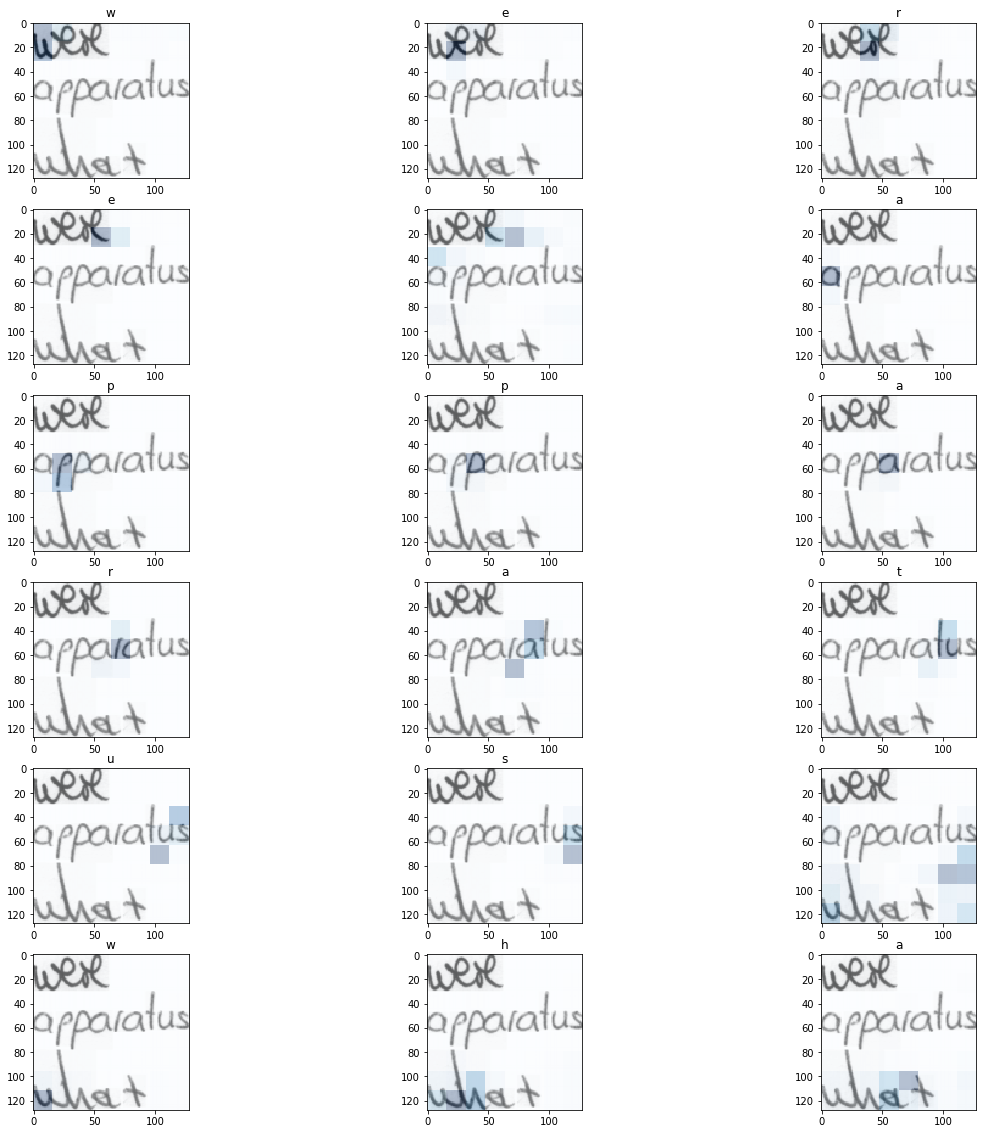

In [62]:
fig, axes = plt.subplots(6, 3, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
#     ax.plot(attn[i])
    a = scale_attn_to_img(attn[i], 128)
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', interpolation='nearest', alpha=0.3)
    ax.set_title(itos[pred[i].item()])